In [ ]:
import os
from tqdm import tqdm
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

### Dataloading

In [ ]:
def load_images(path):

    images = []
    filenames = os.listdir(path)

    for filename in tqdm(filenames):
        if filename == '_DS_Store':
            continue
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.resize(image, dsize=(224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)

    return np.array(images)

In [ ]:
train_normal = load_images("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/")
train_pneumonia = load_images("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/")

100%|██████████| 3875/3875 [01:10<00:00, 54.74it/s]


In [ ]:
X_train = np.append(train_normal, train_pneumonia, axis=0)
y_train = np.array([0] * len(train_normal) + [1] * len(train_pneumonia))

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X_train , y_train , test_size = 0.2 , random_state=42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
y_train = torch.from_numpy(y_train.reshape(len(y_train),1))
y_test =  torch.from_numpy(y_test.reshape(len(y_test),1))

In [ ]:
transforms_train = transforms.Compose([transforms.ToTensor(), # convert to tensor
                                       transforms.RandomRotation(degrees=30),
                                       transforms.RandomVerticalFlip(p=0.005),
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])

In [ ]:
transforms_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

### Dataset class

In [ ]:
class Dataset():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [ ]:
train_dataset = Dataset(images=X_train, labels=y_train, transform=transforms_train)
test_dataset  = Dataset(images=X_test, labels=y_test, transform=transforms_test)

### Dataloader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset , batch_size = 32 , shuffle = True , drop_last = True)

### Model Architecture

In [ ]:
import torch.nn as nn

class ImageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=(4, 4), stride=2)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1)
        )
        self.gradient = None

    def activations_hook(self, grad):
        self.gradient = grad

    def forward(self, image):
        x = self.feature_extractor(image)  # activation_maps
        h = x.register_hook(self.activations_hook)
        x = self.maxpool(x)
        x = self.classifier(x)
        return x

    def get_activations_gradients(self):  # a1, a2, a3, ... ak
        return self.gradient

    def get_activation(self, x):  # A1, A2, A3, ... Ak
        return self.feature_extractor(x)  # 64 x 8 x 8 -> shape of activation layer


### Testing model Shapes

In [ ]:
inputs = torch.randn([32 , 3 , 224 , 224])
model = ImageModel()
output = model(inputs)

In [ ]:
DEVICE = 'cuda'
model = ImageModel().to(DEVICE)
model

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=1, bias=True)
  )
)

### Training Loop

In [ ]:
from tqdm import tqdm

def train_fn(dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(DEVICE).float(), labels.to(DEVICE).float()

        optimizer.zero_grad()
        logits = model(images)

        loss = criterion(torch.sigmoid(logits), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

### Evaluation loop

In [ ]:
def eval_fn(dataloader, model, criterion):
    model.eval()
    total_loss = 0.0
    for images, labels in tqdm(dataloader):

        images, labels = images.to(DEVICE).float(), labels.to(DEVICE).float()

        logits = model(images)

        loss = criterion(torch.sigmoid(logits), labels)
        loss.backward()

        total_loss += loss.item()
    return total_loss/len(dataloader)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training

In [ ]:
EPOCHS = 5
for i in range(EPOCHS):
    train_loss = train_fn(train_loader, model, optimizer, criterion)
    valid_loss = eval_fn(test_loader, model, criterion)

    print(f"EPOCH: [{i+1}/{EPOCHS}], TRAIN LOSS: {train_loss}, VALID LOSS: {valid_loss}")

100%|██████████| 32/32 [00:01<00:00, 21.66it/s]


EPOCH: [1/5], TRAIN LOSS: 0.33094570132402273, VALID LOSS: 0.21169068838935345


100%|██████████| 32/32 [00:01<00:00, 21.70it/s]


EPOCH: [2/5], TRAIN LOSS: 0.18716424657748296, VALID LOSS: 0.10535892879124731


100%|██████████| 32/32 [00:01<00:00, 21.90it/s]


EPOCH: [3/5], TRAIN LOSS: 0.15516730713156554, VALID LOSS: 0.10242609423585236


100%|██████████| 32/32 [00:01<00:00, 21.81it/s]


EPOCH: [4/5], TRAIN LOSS: 0.11754044970282568, VALID LOSS: 0.10351069743046537


100%|██████████| 32/32 [00:01<00:00, 22.13it/s]

EPOCH: [5/5], TRAIN LOSS: 0.1150643556092221, VALID LOSS: 0.08520668552955613


### Plotting and visualizing the results

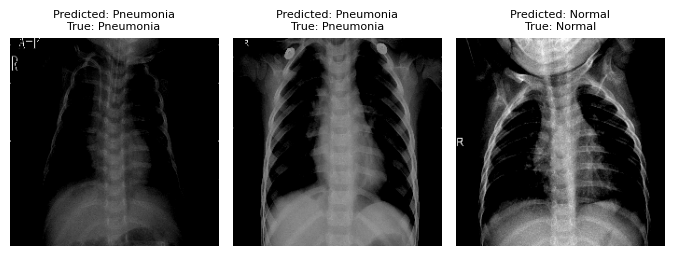

In [ ]:
model.eval()

iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)
img_test = img_test.to(DEVICE)
lbl_test = lbl_test.to(DEVICE)

preds_test = model(img_test)
preds_test = preds_test.cpu()
lbl_test = lbl_test.cpu()
predicted_labels = (preds_test > 0.5).int()


plt.figure(figsize=(18, 12))

num_images = len(lbl_test)
num_rows = 4
num_cols = num_images // num_rows

for i in range(3):
    plt.subplot(num_rows, num_cols, i + 1)
    image_np = img_test[i].cpu().numpy().transpose((1, 2, 0))
    plt.imshow(image_np)
    predicted_class = "Normal" if predicted_labels[i] == 0 else "Pneumonia"
    true_class = "Normal" if lbl_test[i] == 0 else "Pneumonia"

    plt.title(f"Predicted: {predicted_class}\nTrue: {true_class}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


### Gradcam

In [ ]:
def get_gradcam(model, image, label, size):  # size of heatmap
    label.backward()
    gradients = model.get_activations_gradients()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  # a1, a2, a3, ...
    activations = model.get_activation(image).detach()  # A1, A2, A3, ...

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (size, size))

    return heatmap

### Plotting heatmap over image

In [ ]:
def plot_heatmap(denorm_image, pred, heatmap):

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,20), ncols=3)

    classes = ['Pneumonia']
    ps = torch.nn.Sigmoid()(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)

    ax2.barh(classes, ps[0])
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    ax3.imshow(denorm_image)
    ax3.imshow(heatmap, cmap='magma', alpha=0.5)

In [ ]:
def replace_below_threshold(arr, threshold=0.9):
    arr_copy = arr.copy()  # create a copy of the input array to avoid modifying it
    arr_copy[arr_copy < threshold] = 0  # replace values below the threshold with 0
    return arr_copy

tensor([1])
tensor([[7.9362]], device='cuda:0', grad_fn=<AddmmBackward0>)


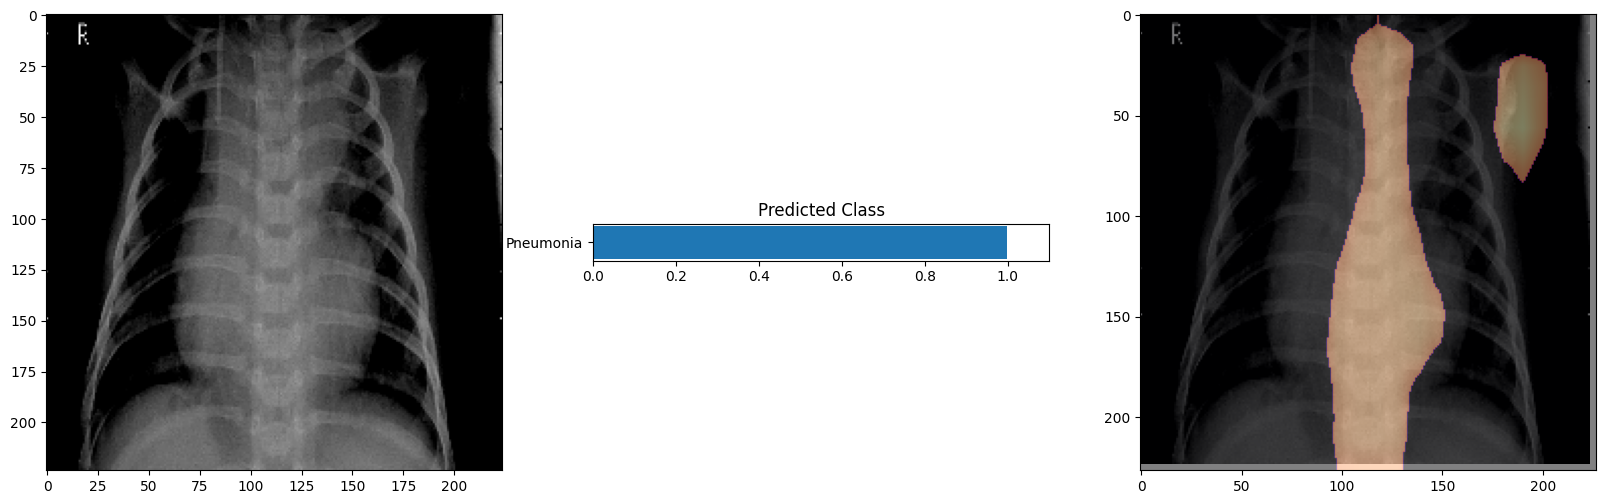

In [ ]:
import matplotlib.pyplot as plt
images, labels = next(iter(test_loader))
image = images[0]
print(labels[0])
denorm_image = image.permute(1, 2, 0)
image = image.unsqueeze(0).to(DEVICE)
pred = model(image)
print(pred)
heatmap_array = get_gradcam(model, image, pred[0][0], size=227)
heatmap = replace_below_threshold(heatmap_array , threshold = 0.8)
plot_heatmap(denorm_image, pred, heatmap)